In [1]:
## Inspiration : 

In [2]:
## upload to github!

## 1) Transformations - keep Normalisation for last
## 2) layer freezing
## 3) Optimizer, Criterion 
## 4) Weighted Loss, check different Loss
## 5) Learning Rate
## 6) Gradient Clip
## 7) 3 Models - Res18, Res50, Vgg19

In [3]:
#### Use Directories:
# layer freezing
# Optimizer
# Criterion(Weighted Loss)

In [4]:
## Transformations
## Learning Rate
## Gradient Clip
## 3 Models - Res18, Res50, Vgg19

In [5]:
import os
import numpy as np
import pandas as pd
from os import listdir, makedirs
from os.path import join, exists, expanduser

import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
# torchvision.models.resnet18
from torchvision import transforms, datasets

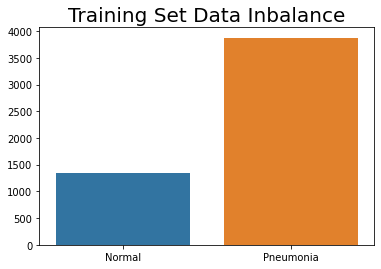

In [6]:
import seaborn as sns
data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray'
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

In [7]:
train_samplesize

,Normal,Pneumonia
0,1342,3876


In [8]:
## Path To Data

In [9]:
ll ../input/chest-xray-pneumonia/chest_xray

total 0
drwxr-xr-x 3 nobody 0 Dec  2  2020 __MACOSX/
drwxr-xr-x 5 nobody 0 Dec  2  2020 chest_xray/
drwxr-xr-x 4 nobody 0 Dec  2  2020 test/
drwxr-xr-x 4 nobody 0 Dec  2  2020 train/
drwxr-xr-x 4 nobody 0 Dec  2  2020 val/


In [10]:
train_data = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_data = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_data = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'

shape:  (1858, 2090)


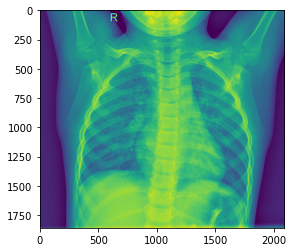

In [11]:
img_path1 = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
img1 = plt.imread(img_path1)
plt.imshow(img1)
print("shape: ", img1.shape)

In [12]:
## Find Mean and Std of Data  ../input/chest-xray-pneumonia/

In [13]:
# mean = 0.
# std = 0.
mean = [0., 0., 0.]
std = [0., 0., 0.]
nb_samples = 0.

def sumOnIndex(data, values):
    for i in range(len(data)):
        data[i]+=values[i]
    return data
    
def normalise(loader):
    mean = [0., 0., 0.]
    std = [0., 0., 0.]
    nb_samples = 0.
    for batch_i, data in enumerate(loader):
        data , _ = data
        batch_samples = data.size(0)
        channels = data.size(1)
        data = data.view(batch_samples, channels, -1)
        data_mean=data.mean(2).sum(0)
        mean = sumOnIndex(mean, data_mean)
        data_std=data.std(2).sum(0)
        std = sumOnIndex(std, data_std)
        nb_samples += batch_samples
    
    for i in range(3):
        mean[i] /= nb_samples
        std[i] /= nb_samples
        
    print("mean : ", mean)
    print("std : ", std)
    _mean = mean
    _std = std
    return _mean, _std

In [14]:
## Image Transforms : Normalisation does not give good results on this dataset.
_mean = torch.tensor([0.2807, 0.2807, 0.2807])
_std = torch.tensor([0.2553, 0.2553, 0.2553])

train_transform = transforms.Compose([
    transforms.CenterCrop(1500),
    transforms.Resize(size=(256, 256)),
    transforms.RandomRotation((-30, 30)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean = _mean,
                         std = _std)
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

In [15]:
## Create Dataset

In [16]:
trainset = datasets.ImageFolder(root = train_data, transform = train_transform)
print(len(trainset))
valset = datasets.ImageFolder(root = val_data, transform = val_transform)
print(len(valset))
testset = datasets.ImageFolder(root = test_data, transform = test_transform)
print(len(testset))

5216
16
624


In [17]:
## Create Data Loader

In [18]:
# trainBatchSize = 32
trainBatchSize = 128
train_loader = DataLoader(dataset=trainset, batch_size=trainBatchSize, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=9, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=9, shuffle=True)

2
0
<class 'torch.Tensor'>
torch.Size([3, 256, 256])
torch.Size([256, 256, 3])


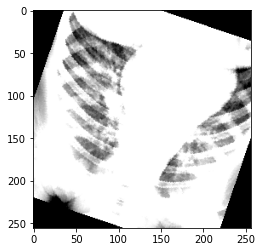

In [19]:
print(len(trainset[0]))
print(trainset[0][1])
img, label = trainset[0]
print(type(img))
print(img.shape)
print(img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0))

torch.Size([3, 256, 256])

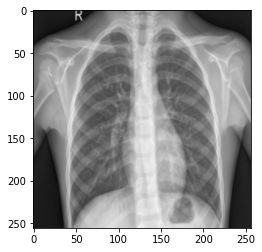

In [20]:
plt.imshow(testset[0][0].permute(1, 2, 0))
testset[0][0].shape

In [21]:
# display 9 imgs
def display_image(imgs, labels, true_labels):
    label_dict = {"0":"Normal", "1":"Pneumonia"}
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    axes = ax.flatten()
    for i in range(9):
        imgs_=imgs[i]
        axes[i].set_title(label_dict[str(labels[i].item())]+", "+label_dict[str(true_labels[i].item())])
        imgs_ = imgs_[:, :, :]
#         print(imgs_.shape)
        axes[i].imshow(np.reshape(imgs_, (256, 256, 3)))

torch.Size([9, 3, 256, 256])


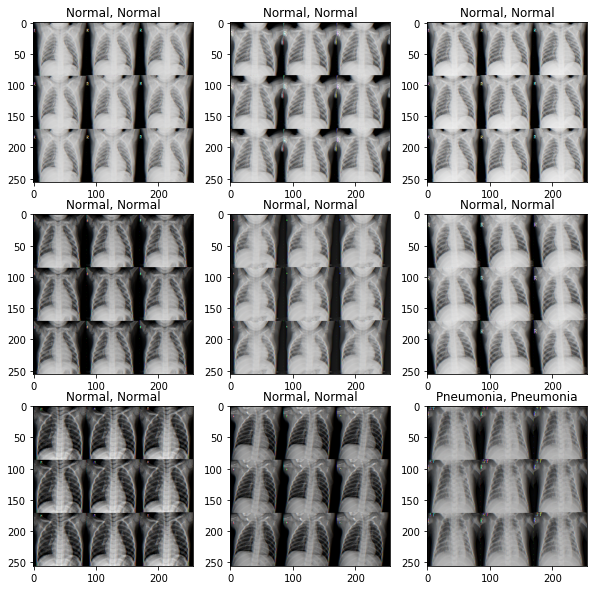

In [22]:
## Check torch.max(outputs, 1)[1]
val_data = next(iter(val_loader))
val_imgs, val_labels = val_data
print(val_imgs.shape)
display_image(val_imgs, val_labels, val_labels)

In [23]:
def to_gpu(resource):
    try:
        if torch.cuda.is_available():
            return resource.to(torch.device('cuda:0'))
        else:
            return resource
    except:
        return resource
    
## without softmax : nn.CrossEntropyLoss uses softmax in their side, we don't need it in our network
def prepResnet18(num_classes=2, pretrained=True):
    resnet18 = models.resnet18(pretrained=pretrained, progress = True)
    resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)
    return resnet18

def prepResnet50(num_classes=2, pretrained=True, imageNet=False):
    resnet50 = models.resnet50(pretrained=pretrained, progress = True)
    resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)
    return resnet50

In [24]:
model=prepResnet18()
model=to_gpu(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [25]:
def accuracy(loader, batch_size, model):
    correct = 0
    len_output = 0
    model.eval()
    for batch_i, data in enumerate(loader):
        images, labels = data
        images, labels = to_gpu(images), to_gpu(labels)
        outputs = model(images)
        correct += (torch.max(outputs, 1)[1]==labels).sum()
        if batch_i==0:
            images=images.cpu().numpy()
            display_image(images, torch.max(outputs, 1)[1], labels)
        
        len_output+=len(outputs)
        
    total = len(loader)* batch_size
    print("correct :", correct)
    print("total :", total)
    return (correct/len_output)*100

correct : tensor(8, device='cuda:0')
total : 18


tensor(50., device='cuda:0')

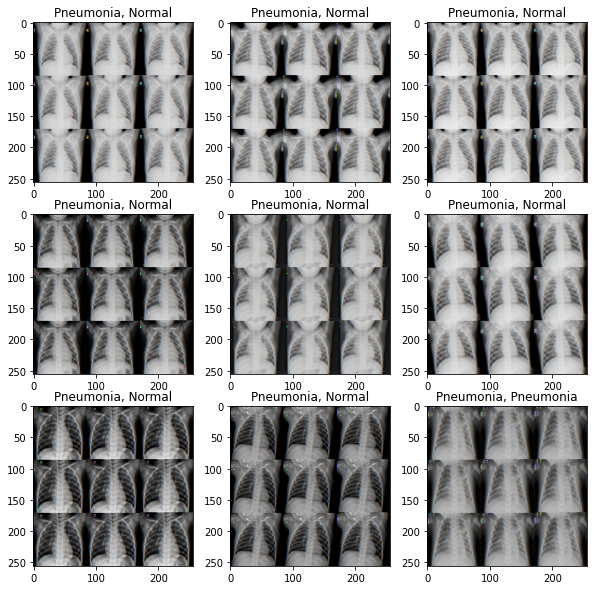

In [26]:
accuracy(val_loader, 9, model)

correct : tensor(390, device='cuda:0')
total : 630


tensor(62.5000, device='cuda:0')

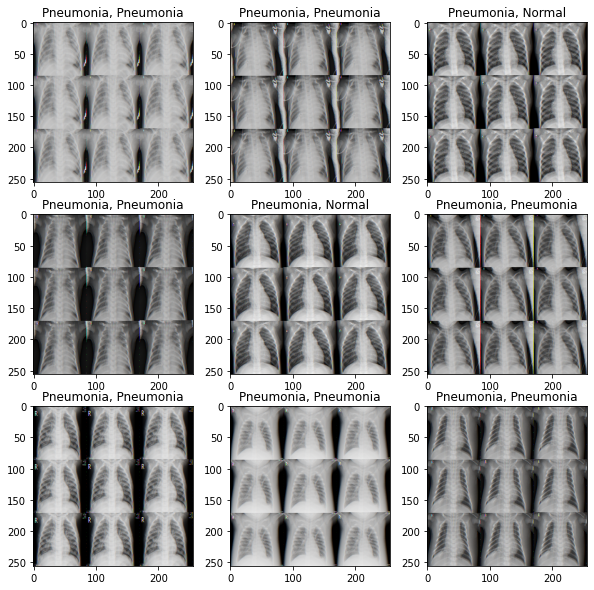

In [27]:
accuracy(test_loader, 9, model)

In [28]:
def prepVgg19(bn=True):
    num_classes = 2
    if not bn:
        vgg19 = models.vgg19(pretrained=True, progress = True)
    else:
        vgg19 = models.vgg19_bn(pretrained=True, progress = True)
        vgg19.classifier.add_module("7", torch.nn.Dropout(p=0.4))
        vgg19.classifier.add_module("8", torch.nn.Linear(1000, num_classes))
    return vgg19

In [29]:
def checkChildren(layer):
    if hasattr(layer, "children"):
        return list(layer.children())
    else:
        return False
def checkWeight(layer):
    if hasattr(layer, "weight"):
        return True
    else:
        return False

def getWeight(layer):
    if checkWeight(layer):
        print(layer, " : ", layer.weight.requires_grad)
    children=checkChildren(layer)
    for child in children:
        checkWeight(child)
        getWeight(child)

In [30]:
l1=list(model.layer3[0].children())
for child in l1:
    if hasattr(child, "weight"):
        print(child, " : ", child.weight.requires_grad)

Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)  :  True
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  True
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True


In [31]:
def initializeResnet18(model, layers=None, freeze_all=False):
    """`freeze all` has priority over `layers`"""
    if layers == []:
        layers = None
    smallestChild = np.inf
    largestChild = 0
    params=[]
    params=list(model.parameters())
    for param in params:
        param.requires_grad_(not freeze_all)
    if not freeze_all:
        params = list(model.parameters())
    if freeze_all:
        params = list(model.fc.parameters())
        for param in params:
            param.requires_grad_(freeze_all)
    elif layers:
        for layer in layers:
            getattr(model, "layer"+str(layer)).requires_grad_(False)
            if layer < smallestChild:
                smallestChild = layer
            if layer > largestChild:
                largestChild = layer
        firstChildren = list(model.children())[:smallestChild+3] # Resnet has 0-3 layers before the blocks
        secondChildren = list(model.children())[4+largestChild:] # 3+1 = 4

        params=[]
        for ele in firstChildren:
            params += ele.parameters()
        for ele in secondChildren:
            params += ele.parameters()
    getWeight(model) 
    print(len(params))
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params,lr = 0.001)
    return criterion, optimizer


In [32]:
def initializeModel(model, freeze_all=False):
    for param in model.parameters():
        param.requires_grad_(not freeze_all)
#     model.fc.requires_grad_(True)
    criterion = torch.nn.CrossEntropyLoss()
    if freeze_all:
        params = model.fc.parameters()
    else:
        params = model.parameters()
    optimizer = torch.optim.Adam(params,lr = 0.001)
    return criterion, optimizer

In [33]:
## RESNET18
# criterion, optimizer = initializeResnet18(model, 2, False)
criterion, optimizer = initializeResnet18(model, [1, 2, ], False)
# print(resnet50)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  :  True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  False
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  False
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  False
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  False
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  False
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  False
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  False
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  False
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)  :  False
BatchNorm2d(128, eps=1e-

In [34]:
# print(T)

In [35]:
### Train

In [36]:
def train(n_epochs, resnet18, loader, criterion, optimizer, weight):

    loss_avg = []
    loss_=[]
    loss_list=[]
    acc_list = []
    resnet18.train()
    r_loss=0
    minAvgLoss = np.inf
    minLoss = np.inf
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        for batch_i, data in enumerate(loader):
            correct = 0
            images, labels = data
            images, labels = to_gpu(images), to_gpu(labels)
            optimizer.zero_grad()
            outputs = resnet18(images)
#             loss = F.cross_entropy(outputs, labels.long(), weight=weight)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loss_list.append(loss.item())
            correct = correct+(torch.max(outputs, 1)[1] == labels).sum()
            acc_list.append(correct/len(labels))
#             if ((batch_i+1) == len(train_loader)):    # print every 1000 mini-batches
        print('Epoch: {}, Acc: {}, Training Loss : {}'.format(epoch + 1, acc_list[-1], running_loss/len(train_loader)))
        r_loss=running_loss
        running_loss = 0.0
        lossAvgItem = r_loss/len(train_loader)
        loss_avg.append(lossAvgItem)
        correct = 0
        loss_.append(loss.item())
        if minLoss>r_loss and minAvgLoss > lossAvgItem:# accuracy > best_accuracy:
            minLoss = r_loss
            minAvgLoss = lossAvgItem
#                best_model = 'best-model-'+str(minAvgLoss)+'.pt'
#                torch.save(model, 'best-model.pt')
            torch.save(model.state_dict(), 'best-model-parameters'+str(minAvgLoss)+'.pt')
                
    return r_loss, resnet18, acc_list, loss_list, loss_, loss_avg

In [37]:
#### 
# 1) Run and check(PLOT) loss with the existing train function : loss = criterion(outputs, labels.long())
# 2) Run with new loss function : loss = criterion(torch.max(outputs, 1)[1], labels.long())

In [38]:
# # 1) Run and check loss with the existing train function : loss = criterion(outputs, labels.long())
# ## Run again!! Epoch = 4
# import time
# t1=time.time()
# r_loss, resnet18, acc_list, loss_list, loss= train(n_epochs=4, resnet18=resnet18)
# print((time.time()-t1)/60)

In [39]:
batchSize = trainBatchSize
# batchSize = 32
dFactor = batchSize/64
dFactor

2.0

In [40]:
e_epoch=3
# e_epoch=3

In [41]:
# 1) Run and check loss with the existing train function : loss = criterion(outputs, labels.long())
## Run again!! Epoch = 4
import time
t1=time.time()
weight = to_gpu(torch.FloatTensor([3875/(1341+3875), 1341/(1341+3875)]))
r_loss, model, acc_list, loss_list, loss, loss_avg= train(n_epochs=e_epoch, resnet18=model, loader=train_loader,
                                                             criterion=criterion, optimizer=optimizer, weight=weight)
print((time.time()-t1)/60)

Epoch: 1, Acc: 0.8854166865348816, Training Loss : 0.42144343765770514
Epoch: 2, Acc: 0.9375, Training Loss : 0.3098344624769397
Epoch: 3, Acc: 0.9270833730697632, Training Loss : 0.26368592279713327
9.164873401323954


In [42]:
# # iter(train_loader)
# val_data = next(iter(train_loader))
# print(len(val_data))

In [43]:
## Run again!! Epoch = 4
num_list = []
for i in range(e_epoch):
    num_list += list(np.linspace(i, i+1 ,int(82/dFactor) , endpoint=False))

In [44]:
len(num_list)

123

In [45]:
len(num_list[0:4075])

123

In [46]:
print(len(num_list))
print(len(loss_list))

123
123


correct : tensor(389, device='cuda:0')
total : 630
accurarcy :  tensor(62.3397, device='cuda:0')


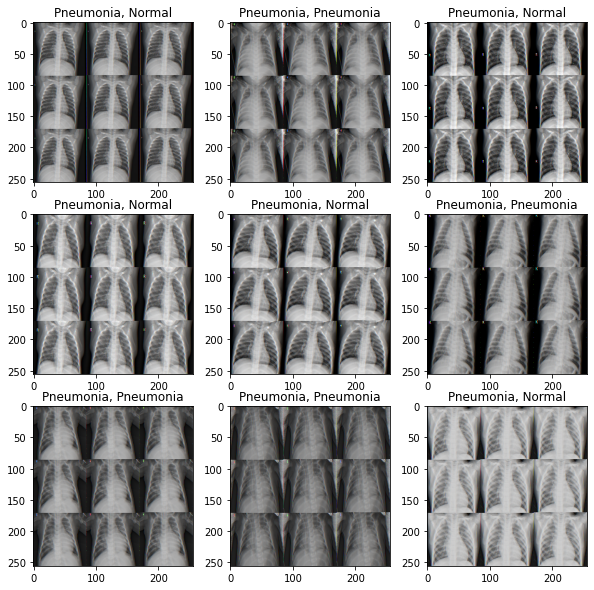

In [47]:
## Find Accuracy on Test Dataset!!
test_loader = DataLoader(dataset=testset, batch_size=9, shuffle=True)
acc = accuracy(test_loader, 9, model)
print("accurarcy : ", acc)

correct : tensor(4772, device='cuda:0')
total : 5216
accuracy :  tensor(91.4877, device='cuda:0')


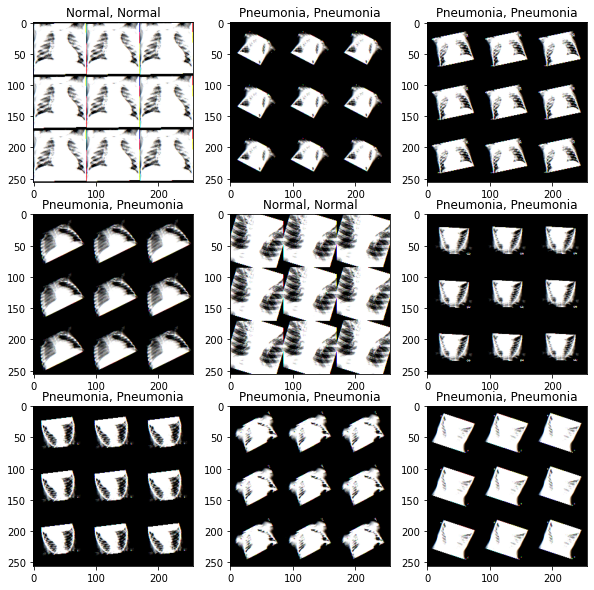

In [48]:
train_loader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
acc = accuracy(train_loader, 32, model)
print("accuracy : ", acc)

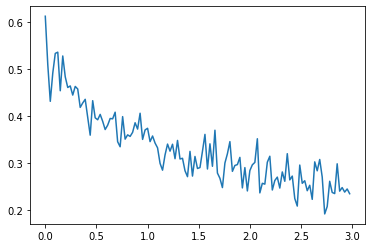

In [49]:
## Run again!! Epoch = 4
# 1) Run and check(PLOT) loss with the existing train function : loss = criterion(outputs, labels.long())
plt.plot(num_list[0:len(loss_list)], loss_list)

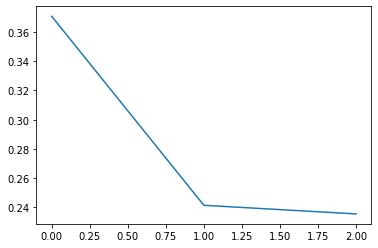

In [50]:
plt.plot([i for i in range(e_epoch)], loss)

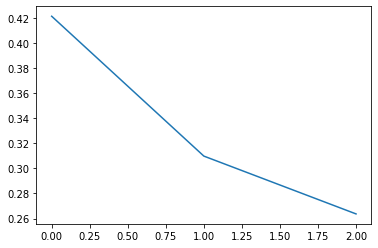

In [51]:
plt.plot([i for i in range(e_epoch)], loss_avg)